In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
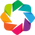

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# do t-test
from scipy.stats import ttest_ind

from SSMuLA.fitness_process_vis import parse_lib_stat
from SSMuLA.de_simulations import DE_COLORS, DE_TYPES, DE_LEGEND_MAP
from SSMuLA.landscape_global import LIB_INFO_DICT
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE, LIB_COLORS
from SSMuLA.zs_analysis import (
    ZS_OPTS,
    ZS_COMB_OPTS,
    ZS_OPTS_LEGEND,
)
from SSMuLA.vis_summary import (
    ZS_OPTS_APPENDED,
    ZS_COLOR_MAP_APPENDED
)

%matplotlib inline

In [4]:
five_zs = {
    "none": PRESENTATION_PALETTE_SATURATE["gray"],
    "ed_score": PRESENTATION_PALETTE_SATURATE["blue"],
    "Triad_score": PRESENTATION_PALETTE_SATURATE["orange"],
    "ev_score": PRESENTATION_PALETTE_SATURATE["green"],
    "esm_score": PRESENTATION_PALETTE_SATURATE["purple"],
    "esmif_score": PRESENTATION_PALETTE_SATURATE["yellow"],
    "coves_score": PRESENTATION_PALETTE_SATURATE["brown"],
}

triad_colors = {
    "Triad-esm_score": PRESENTATION_PALETTE_SATURATE["purple"],
    "Triad-ev_score": PRESENTATION_PALETTE_SATURATE["green"],
    "Triad_score": PRESENTATION_PALETTE_SATURATE["blue"],
    "struc-comb_score": PRESENTATION_PALETTE_SATURATE["yellow"],
}


In [5]:
def get_mlde_avg_df(mlde_all, n_sample, n_top, n_mut_cutoff, zs, active_lib_list):
    avg_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(zs))
        & (mlde_all["n_top"] == n_top)
        & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
        & (mlde_all["n_sample"].isin(n_sample))
        & (mlde_all["rep"].isin(np.arange(50)))
    ][["zs", "lib", "n_sample", "top_maxes", "if_truemaxs"]].groupby(["zs", "lib", "n_sample"]).agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    # avg_mlde = avg_mlde.rename(columns={'n_sample_': 'n_sample'}).set_index("n_sample")
    return avg_mlde

In [6]:
def avg_lib(mlde_all, n_sample, ifzsoret, zsoret, active_lib_list):

    avg_mlde = mlde_all[
            (mlde_all["lib"].isin(active_lib_list))
            & (mlde_all[ifzsoret].isin(zsoret))
            # & (mlde_all["n_top"] == n_top)
            # & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
            & (mlde_all["n_sample"].isin(n_sample))
        ][[ifzsoret, "n_sample", "top_maxes_mean", "if_truemaxs_mean"]].groupby([ifzsoret, "n_sample"]).agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    return avg_mlde

In [7]:
# ft only 12.5
def get_mlde_avg_sdf(mlde_all, n_top, n_sample, n_mut_cutoff, zs, active_lib_list, ft_frac = 0.125, keeplibzs=True):

    if isinstance(zs, str):
        zs = [zs]

    slice_mlde = mlde_all[
        (mlde_all["lib"].isin(active_lib_list))
        & (mlde_all["zs"].isin(zs))
        & (mlde_all["n_top"] == n_top)
        & (mlde_all["n_sample"].isin(n_sample))
        & (mlde_all["n_mut_cutoff"] == n_mut_cutoff)
        & (mlde_all["rep"].isin(np.arange(50)))
    ]

    zs_dfs = []

    for z in zs:
        zs_df = slice_mlde[slice_mlde["zs"] == z].copy()

        if z != "none":
            lib_dfs = []
            for lib in active_lib_list:
                lib_df = zs_df[zs_df["lib"] == lib].copy()
                lib_df["ft_lib_size"] = lib_df["ft_lib"].map(
                    {
                        numb: frac
                        for numb, frac in zip(
                            sorted(lib_df["ft_lib"].unique()), FTLIB_FRAC_LIST
                        )
                    }
                )
                lib_dfs.append(lib_df[lib_df["ft_lib_size"] == ft_frac])
            zs_df = pd.concat(lib_dfs)
        zs_dfs.append(zs_df)
    
    zs_df = pd.concat(zs_dfs)
    
    if keeplibzs:
        add_common = ["zs", "lib"]
    else:
        add_common = []
    
    avg_mlde = zs_df[add_common+["n_sample", "top_maxes", "if_truemaxs"]].groupby(add_common+["n_sample"]).agg(["mean", "std"]).reset_index()
    avg_mlde.columns = ['{}_{}'.format(i, j) for i, j in avg_mlde.columns]
    avg_mlde = avg_mlde.rename(columns={'n_sample_': 'n_sample'}).set_index("n_sample")
    return avg_mlde

In [8]:
N_SAMPLE_LIST = [24, 48, 96, 192, 288, 384, 480, 576, 960, 1920]
FTLIB_FRAC_LIST = [0.125, 0.25, 0.5, 1]
mlde_all = pd.read_csv("results/mlde/all_df_comb_onehot_2.csv")
de_all = pd.read_csv("results/de/DE-active/scale2max/all_landscape_de_summary.csv")
lib_stat  = pd.read_csv("results/corr_3_all/384/boosting|ridge-top96/actcut-1/merge_all.csv")
active_cutoff = 1
active_lib_list = lib_stat[(lib_stat["percent_active"]>active_cutoff)]["lib"].tolist() #  & (lib_stat["percent_measured"] >= 90)

In [10]:
mlde_color_list = ["yellow", "orange", "blue", "green", "purple", "brown"]
more_colors = (
    ["#000000"]
    + [PRESENTATION_PALETTE_SATURATE[c] for c in mlde_color_list]
    + list(ZS_COLOR_MAP_APPENDED.values())[5:9]
    + [
        PRESENTATION_PALETTE_SATURATE["red"],
        PRESENTATION_PALETTE_SATURATE["light_orange"],
        PRESENTATION_PALETTE_SATURATE["light_brown"],
        PRESENTATION_PALETTE_SATURATE["gray"],
        PRESENTATION_PALETTE_SATURATE["light_gray"],
    ]
)

In [11]:
dsdf_mlde_df = (
    get_mlde_avg_sdf(
        mlde_all,
        # n_sample=[96, 384],
        n_sample=N_SAMPLE_LIST,
        n_top=96,
        n_mut_cutoff="double",
        zs=ZS_OPTS,
        active_lib_list=active_lib_list,
    )
)

dsdf_mlde_df["ZS_ensemble"] = dsdf_mlde_df["zs_"].map(lambda x: "Hamming distance +" if x in ZS_OPTS else "Simple")
dsdf_mlde_df


,zs_,lib_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
n_sample,,,,,,,
24,Triad_score,DHFR,0.362452,0.171195,0.00,0.000000,Hamming distance +
48,Triad_score,DHFR,0.340228,0.044874,0.00,0.000000,Hamming distance +
96,Triad_score,DHFR,0.340505,0.000086,0.00,0.000000,Hamming distance +
192,Triad_score,DHFR,0.340514,0.000000,0.00,0.000000,Hamming distance +
288,Triad_score,DHFR,0.340514,0.000000,0.00,0.000000,Hamming distance +
...,...,...,...,...,...,...,...
384,ev_score,TrpB4,0.900188,0.107664,0.47,0.501614,Hamming distance +
480,ev_score,TrpB4,0.900188,0.107664,0.47,0.501614,Hamming distance +
576,ev_score,TrpB4,0.900188,0.107664,0.47,0.501614,Hamming distance +


In [12]:
ds_mlde_df = (
    get_mlde_avg_sdf(
        mlde_all,
        # n_sample=[96, 384],
        n_sample=N_SAMPLE_LIST,
        n_top=96,
        n_mut_cutoff="double",
        zs=["none"],
        active_lib_list=active_lib_list,
    )
)
ds_mlde_df["ZS_ensemble"] = ds_mlde_df["zs_"].map(lambda x: "Hamming distance +" if (x in ZS_OPTS and x != "ed_score") else "Hamming distance")
ds_mlde_df["zs_"] = "ed_score"
ds_mlde_df

,zs_,lib_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
n_sample,,,,,,,
24,ed_score,DHFR,0.884260,0.071623,0.11,0.314466,Hamming distance
48,ed_score,DHFR,0.923741,0.065058,0.17,0.377525,Hamming distance
96,ed_score,DHFR,0.955333,0.059433,0.41,0.494311,Hamming distance
192,ed_score,DHFR,0.987020,0.032284,0.68,0.468826,Hamming distance
288,ed_score,DHFR,0.992195,0.024971,0.75,0.435194,Hamming distance
...,...,...,...,...,...,...,...
384,ed_score,TrpB4,0.797562,0.087125,0.07,0.256432,Hamming distance
480,ed_score,TrpB4,0.782512,0.068551,0.04,0.196946,Hamming distance
576,ed_score,TrpB4,0.789196,0.069327,0.02,0.140705,Hamming distance


In [13]:
full_mlde_df = get_mlde_avg_sdf(
    mlde_all,
    # n_sample=[96, 384],
    n_sample=N_SAMPLE_LIST,
    n_top=96,
    n_mut_cutoff="all",
    zs=["none"] + ZS_OPTS + ["Triad-esm_score", "Triad-ev_score", "struc-comb_score"],
    active_lib_list=active_lib_list,
)

full_mlde_df["ZS_ensemble"] = full_mlde_df["zs_"].map(
    lambda x: "Random"
    if x == "none"
    else (
        "Triad"
        if x == "Triad_score"
        else (
            "Simple" if (x in ZS_OPTS + ["none"] and x != "Triad_score") else "Triad +"
        )
    )
)
full_mlde_df

,zs_,lib_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
n_sample,,,,,,,
24,Triad-esm_score,DHFR,0.900564,0.117381,0.10,0.301511,Triad +
48,Triad-esm_score,DHFR,0.931336,0.068409,0.20,0.402015,Triad +
96,Triad-esm_score,DHFR,0.955833,0.054221,0.20,0.402015,Triad +
192,Triad-esm_score,DHFR,0.986202,0.027481,0.37,0.485237,Triad +
288,Triad-esm_score,DHFR,0.990313,0.024036,0.48,0.502117,Triad +
...,...,...,...,...,...,...,...
384,struc-comb_score,TrpB4,0.773455,0.107375,0.07,0.256432,Triad +
480,struc-comb_score,TrpB4,0.766153,0.096545,0.04,0.196946,Triad +
576,struc-comb_score,TrpB4,0.765372,0.093193,0.04,0.196946,Triad +


In [14]:
merge_ens = pd.concat([full_mlde_df, ds_mlde_df, dsdf_mlde_df])
merge_ens

,zs_,lib_,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
n_sample,,,,,,,
24,Triad-esm_score,DHFR,0.900564,0.117381,0.10,0.301511,Triad +
48,Triad-esm_score,DHFR,0.931336,0.068409,0.20,0.402015,Triad +
96,Triad-esm_score,DHFR,0.955833,0.054221,0.20,0.402015,Triad +
192,Triad-esm_score,DHFR,0.986202,0.027481,0.37,0.485237,Triad +
288,Triad-esm_score,DHFR,0.990313,0.024036,0.48,0.502117,Triad +
...,...,...,...,...,...,...,...
384,ev_score,TrpB4,0.900188,0.107664,0.47,0.501614,Hamming distance +
480,ev_score,TrpB4,0.900188,0.107664,0.47,0.501614,Hamming distance +
576,ev_score,TrpB4,0.900188,0.107664,0.47,0.501614,Hamming distance +


In [15]:
merge_no_ed = merge_ens[merge_ens["ZS_ensemble"].isin(["Simple", "Triad", "Random"])].copy()
merge_no_ed["color"] = merge_no_ed["zs_"].map(lambda x: five_zs[x])
merge_no_ed["Ensemble type"] = "No Hamming distance"
merge_no_ed["zs_"] = pd.Categorical(merge_no_ed['zs_'], categories=list(five_zs.keys()), ordered=True)
merge_no_ed = merge_no_ed.sort_values(by=['zs_',])


merge_w_df = merge_ens[
    merge_ens["ZS_ensemble"].isin(["Hamming distance +", "Hamming distance"])
].copy()
merge_w_df["color"] = merge_w_df["zs_"].map(lambda x: five_zs[x])
merge_w_df["Ensemble type"] = "With Hamming distance"
merge_w_df["zs_"] = pd.Categorical(merge_w_df['zs_'], categories=list(five_zs.keys()), ordered=True)
merge_w_df = merge_w_df.sort_values(by=['zs_',])


merge_no_td = merge_ens[
    merge_ens["ZS_ensemble"].isin(["Simple", "Hamming distance", "Random"])
].copy()
merge_no_td["color"] = merge_no_td["zs_"].map(lambda x: five_zs[x])
merge_no_td["Ensemble type"] = "No Triad"
merge_no_td["zs_"] = pd.Categorical(merge_no_td['zs_'], categories=list(five_zs.keys()), ordered=True)
merge_no_td = merge_no_td.sort_values(by=['zs_',])


merge_w_td = pd.concat(
    [
        merge_ens[merge_ens["ZS_ensemble"].isin(["Triad", "Triad +"])],
        merge_ens[
            (merge_ens["ZS_ensemble"] == "Hamming distance +")
            & (merge_ens["zs_"] == "Triad_score")
        ],
    ]
).copy()
merge_w_td["color"] = merge_w_td["zs_"].map(lambda x: triad_colors[x])
merge_w_td["Ensemble type"] = "With Triad"
merge_w_td["zs_"] = pd.Categorical(merge_w_td['zs_'], categories=list(triad_colors.keys()), ordered=True)
merge_w_td = merge_w_td.sort_values(by=['zs_',])


all_slice_merge = pd.concat([merge_no_ed, merge_w_df, merge_no_td, merge_w_td]).reset_index()
all_slice_merge = all_slice_merge.rename(columns={"zs_": "zs", "lib_": "lib", "n_sample_": "n_sample"})
all_slice_merge

,n_sample,zs,lib,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble,color,Ensemble type
0,1920,none,TrpB4,0.848582,0.104002,0.13,0.337998,Random,#666666,No Hamming distance
1,48,none,ParD3,0.985189,0.019415,0.20,0.402015,Random,#666666,No Hamming distance
2,96,none,ParD3,0.988767,0.005295,0.16,0.368453,Random,#666666,No Hamming distance
3,192,none,ParD3,0.988936,0.004454,0.12,0.326599,Random,#666666,No Hamming distance
4,288,none,ParD3,0.990074,0.005037,0.19,0.394277,Random,#666666,No Hamming distance
...,...,...,...,...,...,...,...,...,...,...
2643,96,struc-comb_score,TrpB3G,0.912762,0.120831,0.63,0.485237,Triad +,#f9be00,With Triad
2644,192,struc-comb_score,TrpB3G,0.959559,0.077848,0.78,0.416333,Triad +,#f9be00,With Triad
2645,288,struc-comb_score,TrpB3G,0.961631,0.072610,0.78,0.416333,Triad +,#f9be00,With Triad
2646,288,struc-comb_score,TrpB3F,1.000000,0.000000,1.00,0.000000,Triad +,#f9be00,With Triad


In [16]:
all_slice_merge.zs.unique()

array(['none', 'Triad_score', 'ev_score', 'esm_score', 'esmif_score',
       'coves_score', 'ed_score', 'Triad-esm_score', 'Triad-ev_score',
       'struc-comb_score'], dtype=object)

In [17]:
avg_mlde_df_dict = {
    "Random": avg_lib(all_slice_merge, N_SAMPLE_LIST, "zs", ["none"], active_lib_list),
}

for zs in ZS_OPTS:
    avg_mlde_df_dict[f"ftMLDE: {ZS_OPTS_LEGEND[zs]}"] = avg_lib(
        all_slice_merge, N_SAMPLE_LIST, "zs", [zs], active_lib_list=active_lib_list
    )

for et in all_slice_merge["Ensemble type"].unique():
    avg_mlde_df_dict[et] = avg_lib(
        all_slice_merge, N_SAMPLE_LIST, "Ensemble type", [et], active_lib_list
    )

for zs, n in zip(
    ["ev_score", "esmif_score"],
    ["EVmutation + Hamming distance", "ESM-IF + Hamming distance"],
):

    df = (
        all_slice_merge[
            (all_slice_merge["zs"] == zs)
            & (all_slice_merge["Ensemble type"] == "With Hamming distance")
        ][["n_sample", "top_maxes_mean", "if_truemaxs_mean"]]
        .groupby(["n_sample"])
        .agg(["mean", "std"])
        .reset_index()
    )
    df.columns = ["{}_{}".format(i, j) for i, j in df.columns]

    avg_mlde_df_dict[n] = df

In [18]:
for zs, n in zip(
    ["ev_score", "esmif_score"],
    ["EVmutation + Edit distance", "ESM-IF + Edit distance"],
):

    df = (
        all_slice_merge[
            (all_slice_merge["zs"] == zs)
            & (all_slice_merge["Ensemble type"] == "With Hamming distance")
        ][["n_sample", "top_maxes_mean", "if_truemaxs_mean"]]
        .groupby(["n_sample"])
        .agg(["mean", "std"])
        .reset_index()
    )
    df.columns = ["{}_{}".format(i, j) for i, j in df.columns]

    avg_mlde_df_dict[n] = df

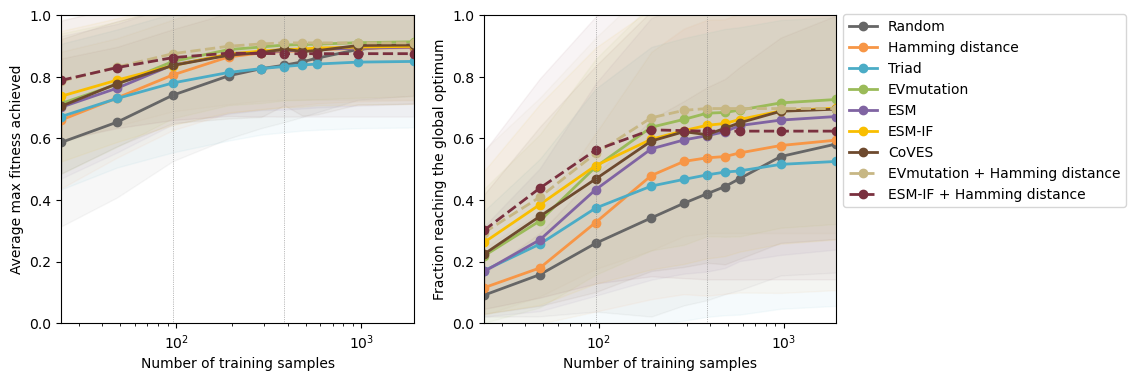

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = [
    "gray",
    "orange",
    "blue",
    "green",
    "purple",
    "yellow",
    "brown",
    "light_brown",
    "maroon",
]
ls = ["solid"] * 7 + ["dashed"] * 2

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes", "if_truemaxs"],
    ["mean_all", "fraction_max"],
    ["Average max fitness achieved", "Fraction reaching the global optimum"],
):

    for i, mlde_opts in enumerate(
        [
            "Random",
            "ftMLDE: Hamming distance",
            "ftMLDE: Triad",
            "ftMLDE: EVmutation",
            "ftMLDE: ESM",
            "ftMLDE: ESM-IF",
            "ftMLDE: CoVES",
            "EVmutation + Hamming distance",
            "ESM-IF + Hamming distance",
        ]
    ):

        mlde_df = avg_mlde_df_dict[mlde_opts]

        ax.plot(
            mlde_df["n_sample_"],
            mlde_df[f"{mlde_metric}_mean_mean"],
            label=mlde_opts.replace("ftMLDE: ", ""),
            marker="o",
            linestyle=ls[i],
            linewidth=2,
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
        )
        ax.fill_between(
            mlde_df["n_sample_"],
            mlde_df[f"{mlde_metric}_mean_mean"] - mlde_df[f"{mlde_metric}_mean_std"],
            mlde_df[f"{mlde_metric}_mean_mean"] + mlde_df[f"{mlde_metric}_mean_std"],
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
            alpha=0.05,
        )

    ax.axvline(96, linestyle="dotted", color="gray", linewidth=0.5)

    ax.axvline(384, linestyle="dotted", color="gray", linewidth=0.5)
    # for de in DE_TYPES:
    #     ax.axhline(
    #         de_avg.loc[de, f"{de_metric}_mean"],
    #         label=f"DE: {DE_LEGEND_MAP[de]}",
    #         color=DE_COLORS[de],
    #         linestyle="dashed",
    #         linewidth=2,
    #     )
    #     ax.fill_between(
    #         N_SAMPLE_LIST,
    #         de_avg.loc[de, f"{de_metric}_mean"] - de_avg.loc[de, f"{de_metric}_std"],
    #         de_avg.loc[de, f"{de_metric}_mean"] + de_avg.loc[de, f"{de_metric}_std"],
    #         color=DE_COLORS[de],
    #         alpha=0.03,
    #     )

    ax.set_xlim(N_SAMPLE_LIST[0], N_SAMPLE_LIST[-1])
    ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel(y_label)

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1.025))

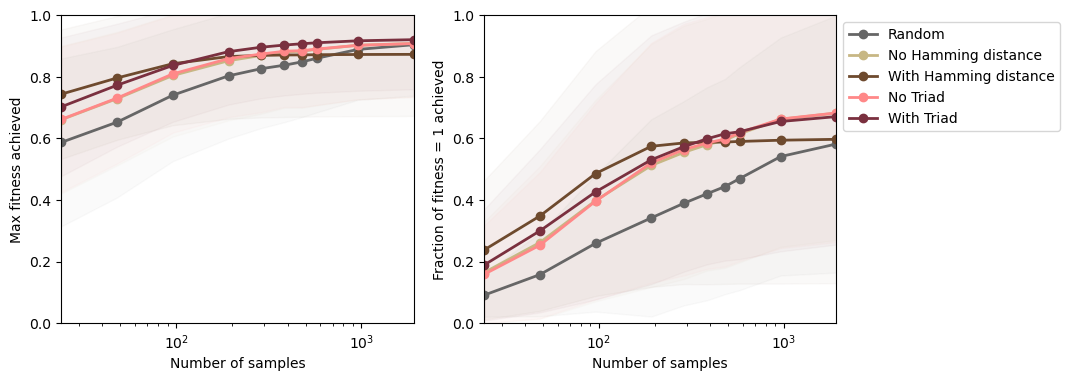

In [20]:
# sup

n_top=96

for et in all_slice_merge["Ensemble type"].unique():
    avg_mlde_df_dict[et]= avg_lib(all_slice_merge, N_SAMPLE_LIST, "Ensemble type", [et], active_lib_list)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = ["gray", "light_brown", "brown", "red", "maroon"]

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes", "if_truemaxs"],
    ["mean_all", "fraction_max"],
    ["Max fitness", "Fraction of fitness = 1"],
):

    for i, mlde_opts in enumerate(["Random"] + list(all_slice_merge["Ensemble type"].unique())):

        mlde_df = avg_mlde_df_dict[mlde_opts]

        ax.plot(
            mlde_df["n_sample_"],
            mlde_df[f"{mlde_metric}_mean_mean"],
            label=mlde_opts,
            marker="o",
            linestyle="solid",
            linewidth=2,
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
        )
        ax.fill_between(
            mlde_df["n_sample_"],
            mlde_df[f"{mlde_metric}_mean_mean"] - mlde_df[f"{mlde_metric}_mean_std"],
            mlde_df[f"{mlde_metric}_mean_mean"] + mlde_df[f"{mlde_metric}_mean_std"],
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
            alpha=0.03,
        )

    # for de in DE_TYPES:
    #     ax.axhline(
    #         de_avg.loc[de, f"{de_metric}_mean"],
    #         label=f"DE: {DE_LEGEND_MAP[de]}",
    #         color=DE_COLORS[de],
    #         linestyle="dashed",
    #         linewidth=2,
    #     )
    #     ax.fill_between(
    #         N_SAMPLE_LIST,
    #         de_avg.loc[de, f"{de_metric}_mean"] - de_avg.loc[de, f"{de_metric}_std"],
    #         de_avg.loc[de, f"{de_metric}_mean"] + de_avg.loc[de, f"{de_metric}_std"],
    #         color=DE_COLORS[de],
    #         alpha=0.03,
    #     )

    ax.set_xlim(N_SAMPLE_LIST[0], N_SAMPLE_LIST[-1])
    ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"{y_label} achieved")

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

# fig.suptitle(
#     "(ft)MLDE Performance Across 10 Minimally Active Landscapes",
#     fontsize=12,
#     fontweight="bold",
#     y=0.95,
# )

In [21]:
PRESENTATION_PALETTE_SATURATE["black"] = "#000000"

In [22]:
len(more_colors)

16

Text(0.5, 0.95, '(ft)MLDE Performance Across 10 Minimally Active Landscapes')

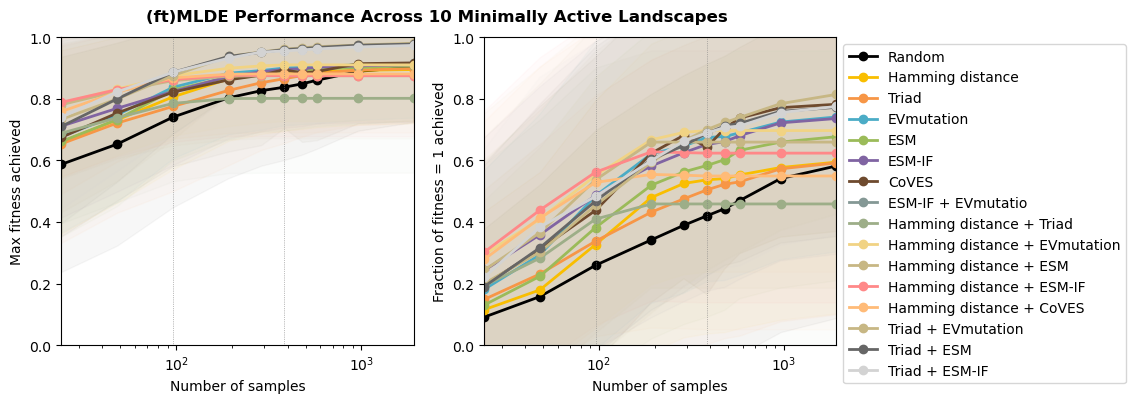

In [23]:
avg_mlde_df_dict = {
    "Random": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["none"], active_lib_list, keeplibzs=False),
    "Hamming distance": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "double", ["none"], active_lib_list, keeplibzs=False),
    "Triad": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["Triad_score"], active_lib_list, keeplibzs=False),
    "EVmutation": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["ev_score"], active_lib_list, keeplibzs=False),
    "ESM": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["esm_score"], active_lib_list, keeplibzs=False),
    "ESM-IF": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["esmif_score"], active_lib_list, keeplibzs=False),
    "CoVES": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["coves_score"], active_lib_list, keeplibzs=False),
    "ESM-IF + EVmutatio": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["two-best_score"], active_lib_list, keeplibzs=False),
    "Hamming distance + Triad": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "double", ["Triad_score"], active_lib_list, keeplibzs=False),
    "Hamming distance + EVmutation": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "double", ["ev_score"], active_lib_list, keeplibzs=False),
    "Hamming distance + ESM": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "double", ["esm_score"], active_lib_list, keeplibzs=False),
    "Hamming distance + ESM-IF": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "double", ["esmif_score"], active_lib_list, keeplibzs=False),
    "Hamming distance + CoVES": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "double", ["coves_score"], active_lib_list, keeplibzs=False),
    "Triad + EVmutation": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["Triad-ev_score"], active_lib_list, keeplibzs=False),
    "Triad + ESM": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["Triad-esm_score"], active_lib_list, keeplibzs=False),
    "Triad + ESM-IF": get_mlde_avg_sdf(mlde_all, 96, N_SAMPLE_LIST, "all", ["struc-comb_score"], active_lib_list, keeplibzs=False),
    # "Avg ftMLDE": ((get_mlde_avg_sdf(mlde_all, 96, "all", ZS_OPTS[1:], active_lib_list)*len(ZS_OPTS[1:]) + get_mlde_avg_sdf(mlde_all, 96, "double", ["none"], active_lib_list)))/(len(ZS_OPTS[1:])+1),
    # "Avg ftMLDE + Hamming ditance": get_mlde_avg_sdf(mlde_all, 96, "double", ZS_OPTS[1:], active_lib_list),
    # "Avg ftMLDE + Triad": (get_mlde_avg_sdf(mlde_all, 96, "all", ["Triad-ev_score", "Triad-esm_score"], active_lib_list)*2 + get_mlde_avg_sdf(mlde_all, 96, "double", ["Triad_score"], active_lib_list))/3
}

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = ["gray", "orange", "blue", "green", "purple", "yellow", "brown"]

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes", "if_truemaxs"],
    ["mean_all", "fraction_max"],
    ["Max fitness", "Fraction of fitness = 1"],
):

    for i, (mlde_opts, mlde_df) in enumerate(avg_mlde_df_dict.items()):

        ax.plot(
            mlde_df.index,
            mlde_df[f"{mlde_metric}_mean"],
            label=mlde_opts,
            marker="o",
            linestyle="solid",
            linewidth=2,
            color=more_colors[i],
        )
        ax.fill_between(
            mlde_df.index,
            mlde_df[f"{mlde_metric}_mean"] - mlde_df[f"{mlde_metric}_std"],
            mlde_df[f"{mlde_metric}_mean"] + mlde_df[f"{mlde_metric}_std"],
            color=more_colors[i],
            alpha=0.03,
        )

    # for de in DE_TYPES:
    #     ax.axhline(
    #         de_avg.loc[de, f"{de_metric}_mean"],
    #         label=f"DE: {DE_LEGEND_MAP[de]}",
    #         color=DE_COLORS[de],
    #         linestyle="dashed",
    #         linewidth=2,
    #     )
    #     ax.fill_between(
    #         N_SAMPLE_LIST,
    #         de_avg.loc[de, f"{de_metric}_mean"] - de_avg.loc[de, f"{de_metric}_std"],
    #         de_avg.loc[de, f"{de_metric}_mean"] + de_avg.loc[de, f"{de_metric}_std"],
    #         color=DE_COLORS[de],
    #         alpha=0.03,
    #     )

    ax.set_xlim(N_SAMPLE_LIST[0], N_SAMPLE_LIST[-1])
    ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"{y_label} achieved")

    # add vertical lines for 96 and 384
    ax.axvline(
        96,
        linestyle="dotted",
        color="gray",
        linewidth=0.5
    )

    ax.axvline(
        384,
        linestyle="dotted",
        color="gray",
        linewidth=0.5
    )

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

fig.suptitle(
    "(ft)MLDE Performance Across 10 Minimally Active Landscapes",
    fontsize=12,
    fontweight="bold",
    y=0.95,
)

In [24]:
merge_simplezs_df = pd.concat([ds_mlde_df, full_mlde_df]).rename(columns={"zs_": "zs", "lib_": "lib", "n_sample_": "n_sample"}).reset_index()
merge_simplezs_df

,n_sample,zs,lib,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble
0,24,ed_score,DHFR,0.884260,0.071623,0.11,0.314466,Hamming distance
1,48,ed_score,DHFR,0.923741,0.065058,0.17,0.377525,Hamming distance
2,96,ed_score,DHFR,0.955333,0.059433,0.41,0.494311,Hamming distance
3,192,ed_score,DHFR,0.987020,0.032284,0.68,0.468826,Hamming distance
4,288,ed_score,DHFR,0.992195,0.024971,0.75,0.435194,Hamming distance
...,...,...,...,...,...,...,...,...
1109,384,struc-comb_score,TrpB4,0.773455,0.107375,0.07,0.256432,Triad +
1110,480,struc-comb_score,TrpB4,0.766153,0.096545,0.04,0.196946,Triad +
1111,576,struc-comb_score,TrpB4,0.765372,0.093193,0.04,0.196946,Triad +
1112,960,struc-comb_score,TrpB4,0.768723,0.095496,0.04,0.196946,Triad +


In [25]:
ds_mlde_df.zs_.unique(), full_mlde_df.zs_.unique()

(array(['ed_score'], dtype=object),
 array(['Triad-esm_score', 'Triad-ev_score', 'Triad_score', 'coves_score',
        'esm_score', 'esmif_score', 'ev_score', 'none', 'struc-comb_score'],
       dtype=object))

Hamming distance : t=0.133 and p=0.900
Triad : t=1.344 and p=0.211
EVmutation : t=0.489 and p=0.640
ESM : t=0.443 and p=0.674
ESM-IF : t=0.674 and p=0.519
CoVES : t=0.725 and p=0.489
ESM-IF
Hamming distance : t=-0.067 and p=0.950
EVmutation
Hamming distance : t=0.936 and p=0.372
Hamming distance : t=-0.773 and p=0.497
Triad : t=-0.103 and p=0.924
EVmutation : t=-0.145 and p=0.892
ESM : t=-0.593 and p=0.593
ESM-IF : t=-0.008 and p=0.994
CoVES : t=0.561 and p=0.609
ESM-IF
Hamming distance : t=-0.494 and p=0.651
EVmutation
Hamming distance : t=-0.372 and p=0.726


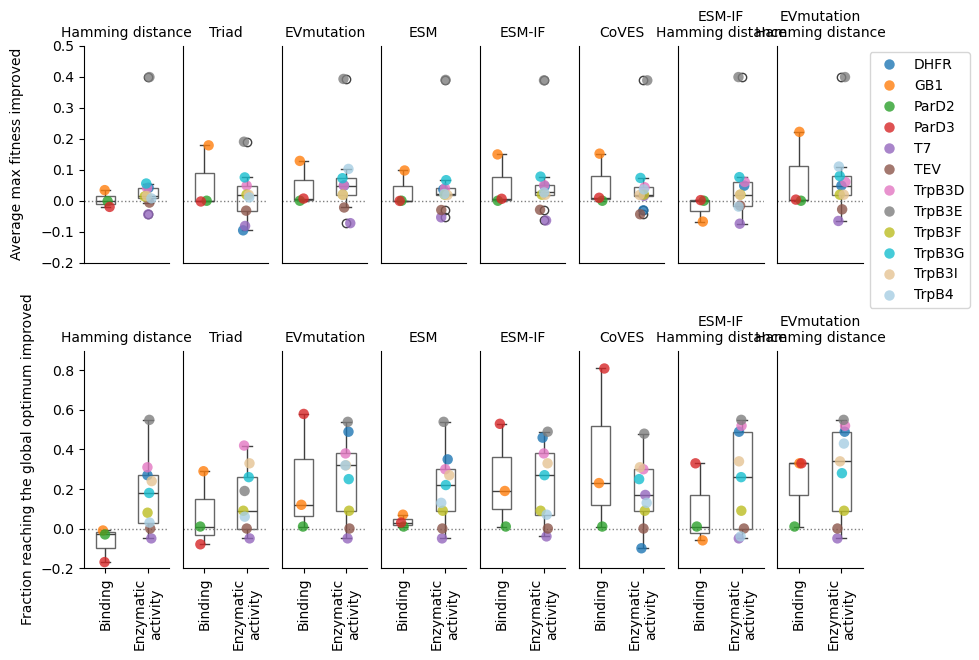

In [26]:
fig, axes = plt.subplots(2, 8, figsize=(9.6, 6.4))

n_sample = 384
slice_df = merge_simplezs_df[(merge_simplezs_df["n_sample"]==n_sample)&(merge_simplezs_df["zs"].isin(["none"] + ZS_OPTS))].copy()

# Convert 'Category' column to categorical with defined order
slice_df['zs'] = pd.Categorical(slice_df['zs'], categories=["none"] + ZS_OPTS, ordered=True)
slice_df = slice_df.sort_values(by=['zs', "lib"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["lib"].map(lambda x: LIB_INFO_DICT[x]["type"])

ens_df = all_slice_merge[all_slice_merge["n_sample"] == n_sample].sort_values(by=["lib"]).copy()
ens_merge_df = pd.concat(
    [
        ens_df[
            (ens_df["zs"] == "esmif_score")
            & (ens_df["Ensemble type"] == "With Hamming distance")
        ],
        ens_df[
            (ens_df["zs"] == "ev_score")
            & (ens_df["Ensemble type"] == "With Hamming distance")
        ],
    ],
)
ens_merge_df["zs"] = ens_merge_df["zs"].map(
    {
        "esmif_score": "ESM-IF\nHamming distance",
        "ev_score": "EVmutation\nHamming distance",
        # **ZS_OPTS_LEGEND,
    }
)
ens_merge_df["type"] = ens_merge_df["lib"].map(lambda x: LIB_INFO_DICT[x]["type"])


ms = ["top_maxes_mean", "if_truemaxs_mean"]
ms_dict = {'top_maxes_mean': "Average max fitness improved", "if_truemaxs_mean": "Fraction reaching the global optimum improved"}


for i in range(len(ms)):
    x = ms[i]
    rand_df = slice_df[slice_df["zs"]=="Random"][["lib", "type", x]].reset_index(drop=True).copy()

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:]) + list(ens_merge_df["zs"].unique())):
        ax = axes[i, z]
        if z<6:
            bar_type_df = slice_df[slice_df["zs"] == zs][["lib", "type", x]].reset_index(drop=True).copy()
        else:
            bar_type_df = ens_merge_df[ens_merge_df["zs"] == zs][["lib", "type", x]].reset_index(drop=True).copy()
        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["lib", "type"], how="outer")
        merg_df["delta"] = merg_df[x+"_x"] - merg_df[x+"_y"]

        sns.boxplot(
            # x="Type", y="Rho", 
            x="type", y="delta", 
            data=merg_df, 
            width=0.45, 
            ax=ax,
            order=["Binding", "Enzymatic activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzymatic activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="lib",
            hue_order=merg_df['lib'].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=sns.color_palette("tab10").as_hex() + ['#e5c494', '#a6cee3'],
            marker="o",
            alpha=0.8,
            ax=ax
        )

        labels = [label.get_text().replace('Enzymatic activity', 'Enzymatic\nactivity') for label in ax.get_xticklabels()]
        
        if i == 0:
            ymax = 0.5
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.2, ymax)
        else:
            ymax = 0.9
            ax.set_xlabel("")
            ax.set_ylim(-0.2, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))
        
        if z==0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks



        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        ax.legend().remove()
        ax.set_title(zs,fontdict={
            'fontsize': 10,
        })
            
        # # Hide the top and right spine
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.axhline(0, color='gray', lw=1, ls="dotted")
        
        # if z != len(ZS_OPTS)-1:
        #     ax.legend().remove()
        # else:
        #     ax.legend(loc="upper left", bbox_to_anchor=(1, 1.0))
        # if z == 0:
        #     ax.set_ylabel(r"Spearman's $\rho$")
        # else:
        #     ax.set_ylabel("")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"]=="Binding"][x]),
            list(bar_type_df[bar_type_df["type"]=="Enzymatic activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p+q)*.5, annot_y, "*", ha='center', va='bottom', color='gray')

axes[0,7].legend(loc="upper left", bbox_to_anchor=(1, 1.0))
plt.tight_layout(pad=0, h_pad=1.0, w_pad=1.0)

In [27]:
slice_df

,n_sample,zs,lib,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble,type
899,384,Random,DHFR,0.951323,0.063437,0.51,0.502418,Random,Enzymatic activity
909,384,Random,GB1,0.677287,0.153190,0.06,0.238683,Random,Binding
919,384,Random,ParD2,0.999913,0.000873,0.99,0.100000,Random,Binding
929,384,Random,ParD3,0.990071,0.004664,0.17,0.377525,Random,Binding
939,384,Random,T7,0.814857,0.122513,0.05,0.219043,Random,Enzymatic activity
...,...,...,...,...,...,...,...,...,...
505,384,CoVES,TrpB3E,0.989424,0.040050,0.93,0.256432,Simple,Enzymatic activity
515,384,CoVES,TrpB3F,1.000000,0.000000,1.00,0.000000,Simple,Enzymatic activity
523,384,CoVES,TrpB3G,0.993904,0.035555,0.97,0.171447,Simple,Enzymatic activity
529,384,CoVES,TrpB3I,0.999254,0.004737,0.97,0.171447,Simple,Enzymatic activity


In [28]:
ens_merge_df

,n_sample,zs,lib,top_maxes_mean,top_maxes_std,if_truemaxs_mean,if_truemaxs_std,ZS_ensemble,color,Ensemble type,type
1257,384,ESM-IF\nHamming distance,DHFR,1.000000,0.000000,1.00,0.000000,Hamming distance +,#f9be00,With Hamming distance,Enzymatic activity
1247,384,ESM-IF\nHamming distance,GB1,0.610227,0.012267,0.00,0.000000,Hamming distance +,#f9be00,With Hamming distance,Binding
1237,384,ESM-IF\nHamming distance,ParD2,1.000000,0.000000,1.00,0.000000,Hamming distance +,#f9be00,With Hamming distance,Binding
1285,384,ESM-IF\nHamming distance,ParD3,0.992152,0.007916,0.50,0.502519,Hamming distance +,#f9be00,With Hamming distance,Binding
1278,384,ESM-IF\nHamming distance,T7,0.740961,0.027444,0.00,0.000000,Hamming distance +,#f9be00,With Hamming distance,Enzymatic activity
1268,384,ESM-IF\nHamming distance,TEV,0.387128,0.011627,0.00,0.000000,Hamming distance +,#f9be00,With Hamming distance,Enzymatic activity
1197,384,ESM-IF\nHamming distance,TrpB3D,1.000000,0.000000,1.00,0.000000,Hamming distance +,#f9be00,With Hamming distance,Enzymatic activity
1201,384,ESM-IF\nHamming distance,TrpB3E,1.000000,0.000000,1.00,0.000000,Hamming distance +,#f9be00,With Hamming distance,Enzymatic activity
1179,384,ESM-IF\nHamming distance,TrpB3F,1.000000,0.000000,1.00,0.000000,Hamming distance +,#f9be00,With Hamming distance,Enzymatic activity
1229,384,ESM-IF\nHamming distance,TrpB3G,0.996512,0.024540,0.98,0.140705,Hamming distance +,#f9be00,With Hamming distance,Enzymatic activity


Hamming distance : t=0.499 and p=0.652
Triad : t=1.379 and p=0.222
EVmutation : t=0.456 and p=0.676
ESM : t=0.347 and p=0.751
ESM-IF : t=0.553 and p=0.615
CoVES : t=0.563 and p=0.610
ESM-IF
Hamming distance : t=-0.023 and p=0.983
EVmutation
Hamming distance : t=0.579 and p=0.585
Hamming distance : t=-0.197 and p=0.859
Triad : t=0.044 and p=0.968
EVmutation : t=0.267 and p=0.807
ESM : t=-0.239 and p=0.829
ESM-IF : t=0.535 and p=0.635
CoVES : t=0.648 and p=0.570
ESM-IF
Hamming distance : t=-0.268 and p=0.806
EVmutation
Hamming distance : t=-0.004 and p=0.997


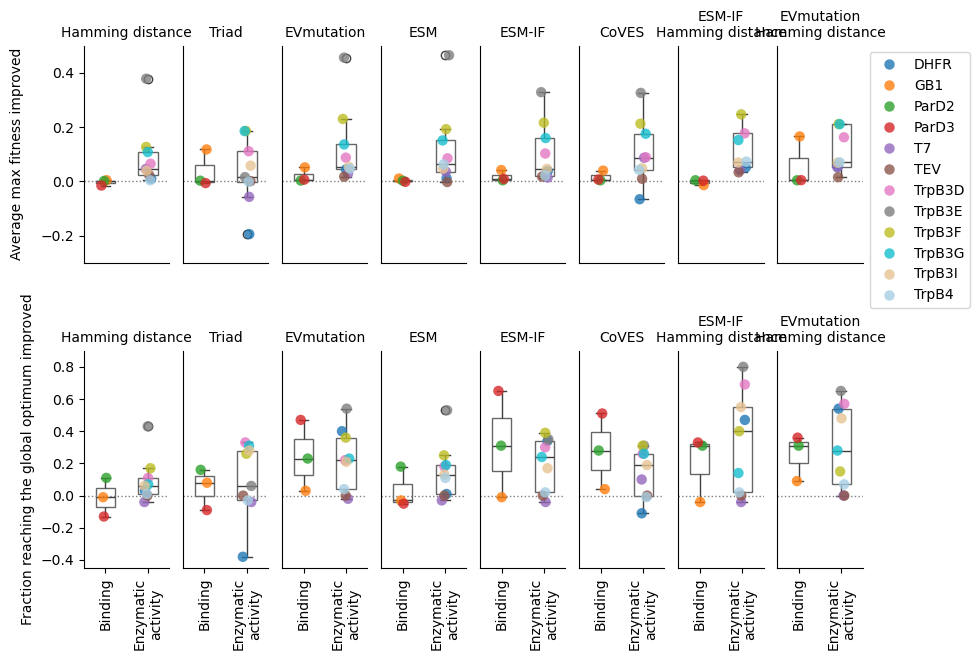

In [69]:
fig, axes = plt.subplots(2, 8, figsize=(9.6, 6.4))

n_sample = 96
slice_df = merge_simplezs_df[(merge_simplezs_df["n_sample"]==n_sample)&(merge_simplezs_df["zs"].isin(["none"] + ZS_OPTS))].copy()

# Convert 'Category' column to categorical with defined order
slice_df['zs'] = pd.Categorical(slice_df['zs'], categories=["none"] + ZS_OPTS, ordered=True)
slice_df = slice_df.sort_values(by=['zs', "lib"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["lib"].map(lambda x: LIB_INFO_DICT[x]["type"])

ens_df = all_slice_merge[all_slice_merge["n_sample"] == n_sample].sort_values(by=["lib"]).copy()
ens_merge_df = pd.concat(
    [
        ens_df[
            (ens_df["zs"] == "esmif_score")
            & (ens_df["Ensemble type"] == "With Hamming distance")
        ],
        ens_df[
            (ens_df["zs"] == "ev_score")
            & (ens_df["Ensemble type"] == "With Hamming distance")
        ],
    ],
)
ens_merge_df["zs"] = ens_merge_df["zs"].map(
    {
        "esmif_score": "ESM-IF\nHamming distance",
        "ev_score": "EVmutation\nHamming distance",
        # **ZS_OPTS_LEGEND,
    }
)
ens_merge_df["type"] = ens_merge_df["lib"].map(lambda x: LIB_INFO_DICT[x]["type"])


ms = ["top_maxes_mean", "if_truemaxs_mean"]
ms_dict = {'top_maxes_mean': "Average max fitness improved", "if_truemaxs_mean": "Fraction reaching the global optimum improved"}


for i in range(len(ms)):
    x = ms[i]
    rand_df = slice_df[slice_df["zs"]=="Random"][["lib", "type", x]].reset_index(drop=True).copy()

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:]) + list(ens_merge_df["zs"].unique())):
        ax = axes[i, z]
        if z<6:
            bar_type_df = slice_df[slice_df["zs"] == zs][["lib", "type", x]].reset_index(drop=True).copy()
        else:
            bar_type_df = ens_merge_df[ens_merge_df["zs"] == zs][["lib", "type", x]].reset_index(drop=True).copy()
        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["lib", "type"], how="outer")
        merg_df["delta"] = merg_df[x+"_x"] - merg_df[x+"_y"]

        sns.boxplot(
            # x="Type", y="Rho", 
            x="type", y="delta", 
            data=merg_df, 
            width=0.45, 
            ax=ax,
            order=["Binding", "Enzymatic activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzymatic activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="lib",
            hue_order=merg_df['lib'].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=sns.color_palette("tab10").as_hex() + ['#e5c494', '#a6cee3'],
            marker="o",
            alpha=0.8,
            ax=ax
        )

        labels = [label.get_text().replace('Enzymatic activity', 'Enzymatic\nactivity') for label in ax.get_xticklabels()]
        
        if i == 0:
            ymax = 0.5
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.3, ymax)
        else:
            ymax = 0.9
            ax.set_xlabel("")
            ax.set_ylim(-0.45, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))
        
        if z==0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks



        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        ax.legend().remove()
        ax.set_title(zs,fontdict={
            'fontsize': 10,
        })
            
        # # Hide the top and right spine
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.axhline(0, color='gray', lw=1, ls="dotted")
        
        # if z != len(ZS_OPTS)-1:
        #     ax.legend().remove()
        # else:
        #     ax.legend(loc="upper left", bbox_to_anchor=(1, 1.0))
        # if z == 0:
        #     ax.set_ylabel(r"Spearman's $\rho$")
        # else:
        #     ax.set_ylabel("")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"]=="Binding"][x]),
            list(bar_type_df[bar_type_df["type"]=="Enzymatic activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p+q)*.5, annot_y, "*", ha='center', va='bottom', color='gray')

axes[0,7].legend(loc="upper left", bbox_to_anchor=(1, 1.0))
plt.tight_layout(pad=0, h_pad=1.0, w_pad=1.0)